In [26]:
include("optimization_library.jl")
include("mplstyle.jl")
import ForwardDiff

# Exercise 12.3

We want to implement the primal-dual interior point method explained in lecture 8. For simplicity we allow only for inequality constraints and omit equality constraints.
We consider the following problem which we have encoutered in Exercise 6.2 in the context of the paint producing company:

  \begin{align*}
    \max_{\vec x} \quad & \vec{c}^{\top} \vec{x}\\
    \text{subject to} \quad & A \vec{x} - \vec{b} \leq \vec{0}
  \end{align*}

  \begin{align*}
    \vec{c}^{\top} = (-2, -3), \quad
     A =
    \begin{pmatrix}
      1 & 0 \\
      0  & 1\\
      2 & 1\\
      1 & 2\\
      -1 & 0\\
      0 & -1
    \end{pmatrix}, \quad
    \vec{b}^{\top} = (-2,-3,-6,-7, 0, 0)
  \end{align*}
    \begin{equation*}
    \vec x^* = (1.67, 2.67)^{\top}
  \end{equation*}

In [27]:
A = [1 0;
    0 1;
    2 1;
    1 2;
    -1 0;
    0 -1]

b = [2,3,6,7,0,0]

# constraint function
g(x) = A*x - b

# number of variables
n_x = 2

# number of constraints
n_constr = length(b);

In [28]:
# construct objective function + gradient + hessian
# luckily we can now employ the magic of automatic differentiation! :)
f(x) = -2*x[1] - 3x[2]
∇f(x) = ForwardDiff.gradient(f, x)
Hf(x) = ForwardDiff.hessian(f, x)


# We construct a vector whose elements are the individual constraint functions
g_vec = Vector(undef, n_constr)
∇g_vec = Vector(undef, n_constr)
Hg_vec = Vector(undef, n_constr)

for i in 1:n_constr
    g_vec[i] = x -> g(x)[i]
    ∇g_vec[i] = x -> ForwardDiff.gradient(g_vec[i], x)
    Hg_vec[i] = x -> ForwardDiff.hessian(g_vec[i], x)
end


# function to construct the jacobian of the constraints g(x)
function Construct_Jacobian(∇g_vec)
    function Jacobian(x)
        n_constr = length(∇g_vec)
        n_x = length(x)
        J = zeros(n_constr,n_x)
        for i in 1:n_constr
            J[i,:] = ∇g_vec[i](x)'
        end
        return J
    end
end

Jg = Construct_Jacobian(∇g_vec);

Implement the residual vector:
\begin{equation}
\vec r_t(\vec x, \vec\mu, \vec \lambda) = \begin{pmatrix}
\nabla f(\vec x) + [\mathcal J \vec g(\vec x)]^{\top} \vec\mu \\
-\text{diag}(\vec\mu) \vec g(\vec x) - \tfrac{1}{t}\vec{1}
\end{pmatrix}
=
\begin{pmatrix}
 \vec r_{\mathrm{dual},t}(\vec z)\\
 \vec r_{\mathrm{cent},t}(\vec z)
 \end{pmatrix}
\end{equation}

In [29]:
function residual(x, μ, t, f, ∇f, g_vec, Jg)
    n_constr = length(g_vec)
    n_x = length(x)
    res = zeros(n_x + n_constr)
    # =======================================================================================
    # Implement the residual vector. Note that each of the two entries is itself again a vector.
    # Hint: use vcat() to stack the two vectors above each other. 
    # You should obtain a vector of length n_x + n_constr
    # =======================================================================================
    return res
end

residual (generic function with 1 method)

In [30]:
# Jacobian of the residual
function J_residual(x, μ, Hf, g_vec, Jg, Hg_vec)
    n_constr = length(g_vec)
    return vcat(
        hcat(Hf(x)+ sum([μ[k] .* Hg_vec[k](x) for k in 1:n_constr]), Jg(x)'),
        hcat(-LA.Diagonal(vec(μ))*Jg(x), -LA.Diagonal(vec([g_vec[k](x) for k in 1:n_constr])))
    )
end

J_residual (generic function with 1 method)

In [31]:
# duality gap
function dualtiy_gap(x,μ, g_vec)
    # =======================================================================================
    # Implement the duality gap
    # =======================================================================================
    return 0
    
end

dualtiy_gap (generic function with 1 method)

In [32]:
# dual line search
# z: vector containing primal and dual variables, i.e. z = (x,μ)
# Δz: Newton step according to modified KKT condition
# t: scaling of barrier function
# f: objective function
# g: vector of constraint functions
# Jg: function that returns the jacobian of the constraints
# p: step length reduction
# β: minimum descent
function dual_linesearch(z, Δz, t, f, g, Jg; p=0.8, β = 0.01)

    n_constr = length(g)
    n_z = length(z)
    n_x = n_z - n_constr
    
    μ = z[n_x+1:end]
    x = z[1:n_x]
    Δμ = Δz[n_x+1:end]
    Δx = Δz[1:n_x]
      
    
    α_max = 1000
    # define the maximum step length
    for k in 1:length(μ)
        if (Δμ[k] < 0)
             α_max = min(α_max, - μ[k]/Δμ[k])
        end
    end
    α_max = min(1,α_max)
    
    # move a bit below the maximum step length
    α = 0.99*α_max
    
    # =======================================================================================================
    # reduce the step length by p until the constraints are fulfilled and 
    # until ∥r_t(z + α∆z)∥ < (1 − αβ )∥r_t(z)∥
    # =======================================================================================================
    
    return α
end;

In [33]:
# primal dual interior point method
# f: objective function
# df: gradient of objective function
# Hf: Hessian of objective function
# z0: initial vector containing primal and dual variables, i.e. z0 = (x0,μ0)
# Jg: function that returns the jacobian of the constraints
# g: vector of constraint functions
# Hg: vector of with Hessiants of constraint functions
# ρ: scaling by which the barrier t increases
# initial_barrier: value of initial barrier t
# maxiters: maximum number of primal-dual steps
# ϵ_feas: precision of residual
# ϵ: precision of duality gap
function primal_dual_ipm(f, df, Hf, z0, Jg; g = [], Hg = [], ρ = 10, initial_barrier = 1.0,
             maxiters=100, ϵ_feas=0.01, ϵ = 0.01)

    n_constr = length(g)
    n_z = length(z0)
    n_x = n_z - n_constr
    
    t = initial_barrier
    z = copy(z0)
    
    trace = [z[1:n_x]; f(z[1:n_x])]
    gap_trace = dualtiy_gap(z[1:n_x],z[n_x+1:end], g)

    for i in 1:maxiters

        μ = z[n_x+1:end]
        x = z[1:n_x]
        
        res = residual(x,μ,t, f, ∇f, g, Jg)
        gap = dualtiy_gap(x,μ, g)
        
        # =======================================================================================================
        # Implement the following steps:
        
        # 1. break the loop if the norm of the dual residual (r_dual,t(z)) fufills the precision ϵ_feas or
        # if the surrogate duality gap fulfills the precision ϵ
        
        # 2. evaluate the barrier scaling t
        
        # 3. evaluate the step direction Δz
    
        # 4. perform dual line search to get the step length and update z
        
        # =======================================================================================================
        
        trace = hcat(trace,[z[1:n_x]; f(z[1:n_x])])
        gap_trace = [gap_trace; gap]
    
    end
    
    return z[1:n_x], trace, gap_trace
end

primal_dual_ipm (generic function with 1 method)

In [34]:
# initialize the variables for our given example from above.
x_init = [1,1]
μ_init = rand(n_constr,1)*10
z0 = vcat(x_init,μ_init);

# optimize by primal dual interior point method
xstar, trace, gap_trace = primal_dual_ipm(f, ∇f, Hf, z0, Jg; g = g_vec, Hg = Hg_vec, ρ = 10, initial_barrier = 1.0,
             maxiters=100, ϵ_feas=0.0001, ϵ = 0.0001)

([1.0, 1.0], [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; -5.0 -5.0 … -5.0 -5.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
# Ensure that we get the right result with our implemented methods.
@assert LA.norm(xstar - [1.67; 2.67]) < 0.01

LoadError: AssertionError: LA.norm(xstar - [1.67; 2.67]) < 0.01

In [36]:
# use the interior point method working only on the primal variables
xstar_primal, trace_primal, gap_trace_primal = ipm(f, ∇f, Hf, x_init; g=g_vec, dg=∇g_vec, Hg= Hg_vec,
             initial_barrier = 1.0, barrier_increase = 2.0,
             maxiters=100, inner_maxiters=100,
             ls=true, eps=0.0001)

([1.6666227133079716, 2.6666762621429885], [1.0 1.0343176997278642 … 1.6666227133079716 1.6666227133079716; 1.0 2.2889818103959665 … 2.6666762621429885 2.6666762621429885; -8.178053830347945 -10.245261529364623 … -11.332640469979992 -11.33295734151245; 0.0 5.0 … 2.0 1.0], [6.0, 6.0, 3.0, 1.5, 0.75, 0.375, 0.1875, 0.09375, 0.046875, 0.0234375, 0.01171875, 0.005859375, 0.0029296875, 0.00146484375, 0.000732421875, 0.0003662109375, 0.00018310546875, 9.1552734375e-5])

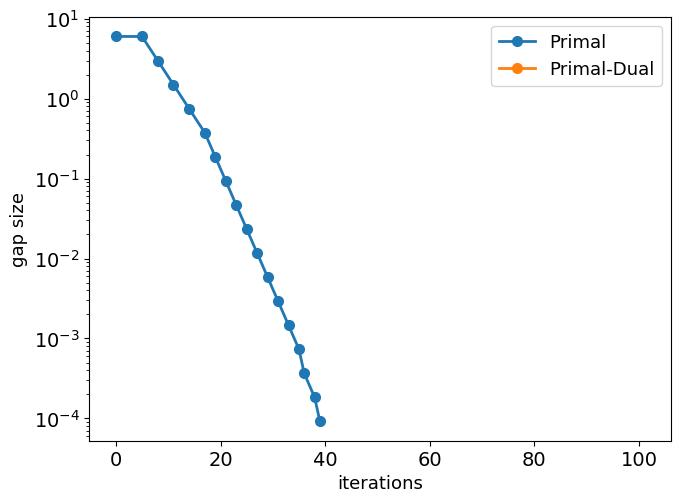

In [37]:
# plot duality gap as function of number of iterations for both algorithms
fontsize = 13
plot(cumsum(trace_primal[end,:]), gap_trace_primal, marker = "o", label = "Primal")
plot(1:length(gap_trace), gap_trace, marker = "o", label = "Primal-Dual")
ylabel("gap size", fontsize = fontsize)
xlabel("iterations",fontsize = fontsize)
legend(fontsize = fontsize)
PyPlot.yscale("log")